# 0 Imports

In [42]:
import pickle
import datetime
import inflection

import numpy    as np
import pandas   as pd
import seaborn  as sns

from matplotlib import pyplot as plt

from IPython.display        import Image
from IPython.core.display   import HTML

## 0.1 Funções Suporte

In [43]:
# Supressão da notação científica.
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.6f}'.format)

In [44]:
def estatistica_descritiva(df1):
    # Medidas de tendência central - Mean, Median
    media = pd.DataFrame(df1.apply(np.mean)).T
    mediana = pd.DataFrame(df1.apply(np.median)).T
    
    # Medidas de Dispersão - Std, min, max, range, skew, kurtosis
    desvio_padrao = pd.DataFrame(df1.apply(np.std)).T
    minimo = pd.DataFrame(df1.apply(np.min)).T
    maximo = pd.DataFrame(df1.apply(np.max)).T
    range = pd.DataFrame(df1.apply(lambda x : x.max() - x.min())).T
    assimetria = pd.DataFrame(df1.apply(lambda x : x.skew())).T
    curtosis = pd.DataFrame(df1.apply(lambda x : x.kurtosis())).T
    
    estatistica = pd.concat([minimo, maximo, range, media, mediana, desvio_padrao, assimetria, curtosis]).T.reset_index()
    estatistica.columns = ['variaveis','minimo', 'maximo', 'range', 'media', 'mediana', 'desvio_padrao', 'assimetria', 'curtosis']
    
    return estatistica

In [45]:
def visualizacao_dados_categoricos(df):
    for i in df:
        print(f'Atributo: {i}') 
        print(f'Valores Únicos: {len(df[i].sort_values().unique())}')
        print(f'Valores Descritos: {df[i].sort_values().unique().tolist()}\n')

In [46]:
## Function to reduce the DF size
## It is necessary that after using this code, carefully check the output results for each column.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 10242
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 10242
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [47]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18,10]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width: 100% !important;} </style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [48]:
def importar_arquivos()-> list:
    """
    Método para importar os DataFrames salvos no formato pkl.
    Por enquanto não vamos receber dados externos, mas no futuro isso será implementado.
    """
    
    arquivos = os.listdir(__CAMINHO_RAW)
    lista_arquivos = [arquivo for arquivo in arquivos if arquivo.endswith('.csv')]
    
    return lista_arquivos

In [49]:
def exportar_df(df: pd.DataFrame):
    df.to_pickle(f'{__CAMINHO_INTERIM}/1_0_descricao.pkl')

In [50]:
def renomear_colunas(df: pd.DataFrame)-> pd.DataFrame:
    
    columns_old = df.columns
    snakecase = lambda x : inflection.underscore(x)
    columns_new = list(map(snakecase,columns_old))
    df.columns = columns_new
    
    return df

In [51]:
def mundaca_tipo_date(df: pd.DataFrame)-> pd.DataFrame:
    df['date'] = pd.to_datetime( df['date'] )
    return df

In [52]:
def mesclar_arquivos(lista_arquivos: list,)-> pd.DataFrame:
    """
    Método para meclar os DataFrames. Aporveito para acrescentar 1 coluna de identificação da tabela.
    Preciso colocar essa identificação para não misturar os dados na hora da análise.
    """
    dfs = pd.DataFrame()
    for arquivo in lista_arquivos:
    
        df = pd.read_csv( os.path.join( __CAMINHO_RAW, arquivo ) )
        maquina = arquivo.split('_')[1]
        df['maquina'] = maquina
    
        df = renomear_colunas(df)
        df = mundaca_tipo_date(df)

        if dfs.empty:
            dfs = df
        else:
            if maquina in dfs['maquina'].values:

                date = dfs.loc[dfs['maquina'] == maquina, 'date']
                filtro = date.max()
                df = df.loc[df['date'] > filtro]
                
                dfs = pd.concat([dfs,df], ignore_index=True)
            else:
                dfs = pd.concat([dfs,df], ignore_index=True)

    return dfs

## 0.2 Load Data

In [53]:
__CAMINHO_RAW = '../data/raw/'
#__CAMINHO_RAW = 'E:/4_arquivos/1_projeto/modelo_unicin/src/data/raw'

__CAMINHO_INTERIM = '../data/interim'


In [54]:
lista_arquivos = importar_arquivos()

## 0.3 Ajuste primário

In [55]:
df = mesclar_arquivos(lista_arquivos=lista_arquivos)

# 1.0 Descrição dos Dados

## 1.1 Data Sample

In [56]:
df.iloc[len(df):(len(df)-300):-30]

,subscription_name,subscription_guid,date,resource_guid,service_name,service_type,service_region,service_resource,quantity,cost,maquina
59285,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-31,40551b4c-e8be-48ed-b70b-f8d25c7de724,Storage,General Block Blob,All,Read Operations,0.000800,0.000000,unicin
59255,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-21,8dbc6497-3d3a-47d6-9de4-dd42072fad66,Storage,Standard Page Blob,BR South,LRS Data Stored,0.001248,0.000144,unicin
59225,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-31,2f2a1523-d8af-5cea-9b91-d0285e17e343,Backup,All,BR South,Azure VM Protected Instances,0.008064,0.080640,unicin
59195,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-21,e53063d5-dd23-4bdf-a1df-cdfe862d01ab,Storage,Standard SSD Managed Disks,BR South,E3 LRS Disk,0.064512,0.144528,unicin
59165,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-31,05212985-faad-4b6c-8ddb-c08cc8e37f79,Storage,Premium Page Blob,US East,P10 LRS Disk,0.052416,1.033123,unicin
59135,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-21,43034668-a244-4031-bb4d-be5bcce22c5f,Bandwidth,Inter-Region,Intercontinental,Inter Continent Data Transfer Out - LATAM To Any,0.000134,0.000009,unicin
59105,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-31,d23a5753-ff85-4ddf-af28-8cc5cf2d3882,Storage,Standard Page Blob,All,LRS Data Stored,0.000078,0.000000,unicin
59075,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-21,cd4cfb51-f027-4d88-89d0-80e78795f00e,Backup,All,BR South,GRS Data Stored,1.612248,0.098352,unicin
59045,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-31,b9e5e77c-a0b3-4a2c-9b8b-57fa54f31c52,Storage,Tables,All,Batch Write Operations,0.016000,0.000000,unicin
59015,Microsoft Azure Sponsorship,15dc64f3-696a-48fc-9169-8467e3f7bba0,2024-10-21,26ce34b7-67b3-480d-9d1b-54a7fb80f67a,Virtual Network,IP Addresses,All,Basic IPv4 Static Public IP,24.000000,0.086400,unicin


In [57]:
a = 123
c = "int"
var_aux = [123,312,345,645,567,876,"!@3234234"]

In [58]:
df2 = df.copy()

## 1.2 Data Dimension

In [59]:
df.shape

(59286, 11)

## 1.3 Data Types

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59286 entries, 0 to 59285
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   subscription_name  59286 non-null  object        
 1   subscription_guid  59286 non-null  object        
 2   date               59286 non-null  datetime64[ns]
 3   resource_guid      59286 non-null  object        
 4   service_name       59286 non-null  object        
 5   service_type       59286 non-null  object        
 6   service_region     59286 non-null  object        
 7   service_resource   59286 non-null  object        
 8   quantity           59286 non-null  float64       
 9   cost               59286 non-null  float64       
 10  maquina            59286 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 5.0+ MB


In [61]:
df.isna().sum()

subscription_name    0
subscription_guid    0
date                 0
resource_guid        0
service_name         0
service_type         0
service_region       0
service_resource     0
quantity             0
cost                 0
maquina              0
dtype: int64

## 1.5 Estatística Descritiva

In [62]:
variaveis_categoricas = df.select_dtypes( exclude = [ 'int32','int64', 'float64','datetime64[ns]'])
variaveis_numericas = df.select_dtypes( include = [ 'int32','int64', 'float64'])

### 1.5.1 Variáveis Numéricas

In [63]:
estatistica_numerica = estatistica_descritiva(variaveis_numericas)
estatistica_numerica

,variaveis,minimo,maximo,range,media,mediana,desvio_padrao,assimetria,curtosis
0,quantity,0.000000,832.332400,832.332400,7.981463,0.094547,26.276567,8.617708,122.844306
1,cost,0.000000,14.386982,14.386982,0.372963,0.014329,0.850807,4.957950,51.905209


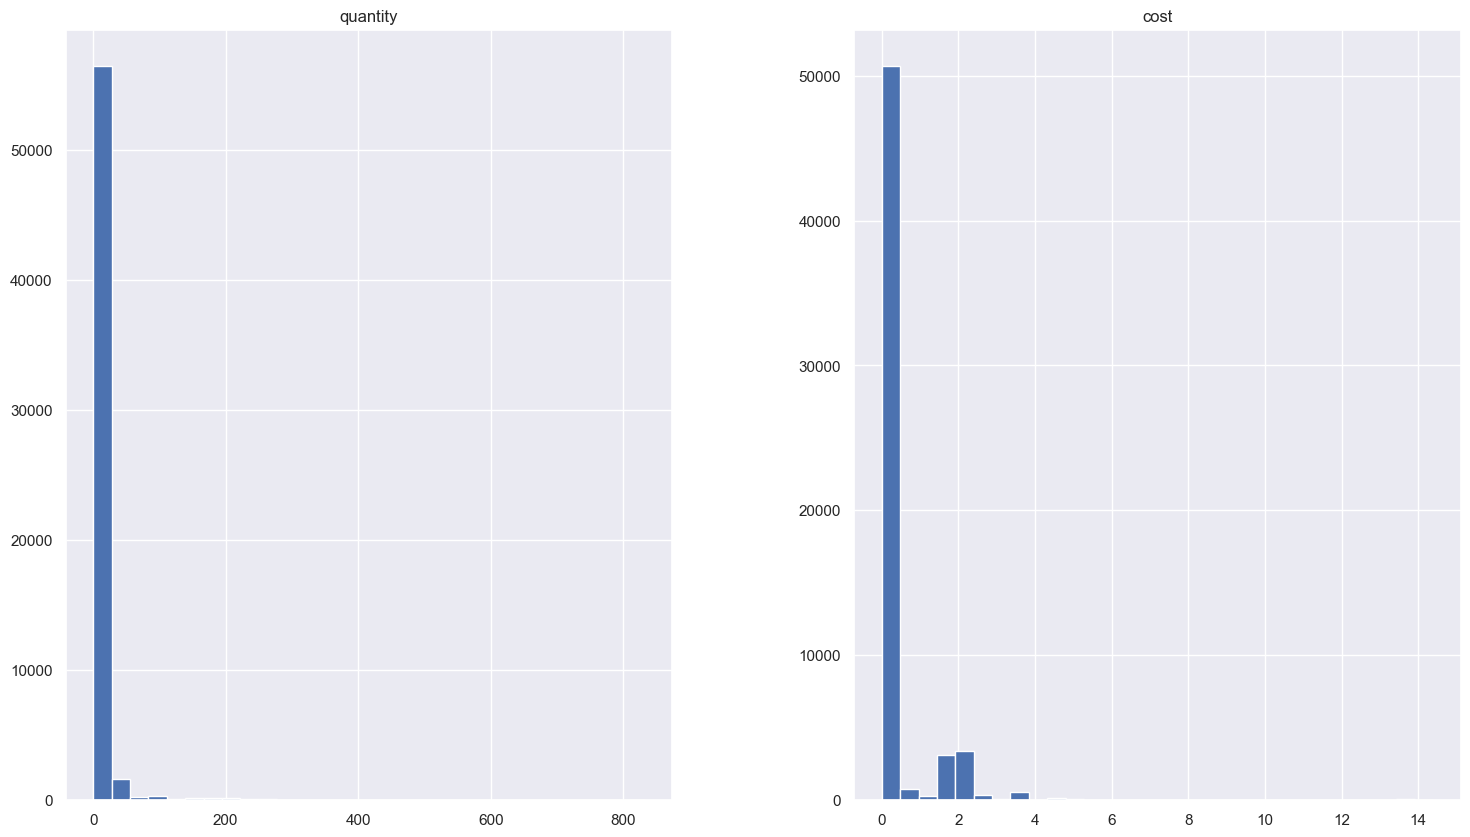

In [64]:
variaveis_numericas.hist(bins = 30);

In [65]:
#df['week_of_year'].hist(bins = 52);

KeyError: 'week_of_year'

### 1.5.2 Vairiáveis Categóricas

In [66]:
variaveis_categoricas.describe().T

,count,unique,top,freq
subscription_name,59286,1,Microsoft Azure Sponsorship,59286
subscription_guid,59286,4,0b1856f5-ffb1-4fb2-9b31-ebc3ddeacf68,27095
resource_guid,59286,92,c089a13a-9dd0-44b5-aa9e-44a77bbd6788,2628
service_name,59286,16,Storage,29414
service_type,59286,30,All,13169
service_region,59286,7,All,26831
service_resource,59286,67,LRS Data Stored,7304
maquina,59286,4,ceaec,27095


In [67]:
visualizacao_dados_categoricos(variaveis_categoricas)

Atributo: subscription_name
Valores Únicos: 1
Valores Descritos: ['Microsoft Azure Sponsorship']

Atributo: subscription_guid
Valores Únicos: 4
Valores Descritos: ['0b1856f5-ffb1-4fb2-9b31-ebc3ddeacf68', '15dc64f3-696a-48fc-9169-8467e3f7bba0', '82375e17-0dda-4790-b6e8-c565d4f08e87', 'e567a9da-afce-49f1-86e3-86f976ff5fcf']

Atributo: resource_guid
Valores Únicos: 92
Valores Descritos: ['01caecf8-c1e4-4885-8c13-3292721482fe', '05212985-faad-4b6c-8ddb-c08cc8e37f79', '0b248445-aa24-4fe8-a794-a174929327bd', '0b608a26-f611-4232-8192-ce81b6b57194', '0ddb5c81-143d-52f8-9ea3-29b64cc0ef97', '0f68ed30-d33d-4b1b-8533-f16ae059f71d', '0f824807-2376-435c-95c9-f992b67a07b0', '0fcb37f3-8a5a-4e81-820e-848908a57e44', '11ecb7d4-b18a-447a-bb0c-f057585fc701', '12da282f-7e96-49e2-983a-9a65da2a4866', '13c2d6a4-7f53-47a9-b6aa-8bb6167ac54d', '17b3fc96-9141-4e25-88f2-b8953f3ca784', '1adb9ebc-c08f-426d-9aa4-8af9de7b6d74', '1b74a37f-45a2-4266-bf07-2764801d0b85', '211e620c-ebcf-4db5-a7fd-996abebe9546', '26ce34b7-67

# 1.6 Export PKL

In [68]:
exportar_df(df=df)